<a href="https://colab.research.google.com/github/Nazmul92/FL/blob/main/Different_aggregation_technique_in_FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install syft==0.2.9 -f https://download.pytorch.org/whl/torch_stable.html     ## install syft

# Import libraries

In [ ]:
import torch
import syft as sy
from sklearn.datasets import load_iris
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
hook = sy.TorchHook(torch)                      ## create hook using syft (extension of torch)

# Define virtual worker

In [ ]:
worker1 = sy.VirtualWorker(hook, id = 'worker1')                       
worker2 = sy.VirtualWorker(hook, id = 'worker2')
worker3 = sy.VirtualWorker(hook, id = 'worker3')
worker4 = sy.VirtualWorker(hook, id = 'worker4')
worker_trusted = sy.VirtualWorker(hook, id='worker_trusted')

# Load data

In [ ]:
df = load_iris()
x = df.data                             ## define features
y = df.target                           ## define target

x_tensor = torch.tensor(x)              ## convert numpy to torch
y_tensor = torch.tensor(y)

# Distribute data among virtual worker

In [ ]:
data_worker1 = x_tensor[0:40].send(worker1)                       ## first 40 sample data send to worker1
target_worker1 = y_tensor[0:40].send(worker1)                     ## first 40 target data sent to worker1

data_worker2 = x_tensor[40:80].send(worker2)                      ## second 40 sample data send to worker2
target_worker2 = y_tensor[40:80].send(worker2)                    ## second 40 target data send to worker2

data_worker3 = x_tensor[80:120].send(worker3)                     ## third 40 sample data send to worker3
target_worker3 = y_tensor[80:120].send(worker3)                   ## third 40 target data send to worker3

data_worker4 = x_tensor[110:].send(worker4)                       ## sample 110 to rest send to worker4
target_worker4 = y_tensor[110:].send(worker4)                     ## target 110 to rest send to worker4

# Define model 

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(4,50)                                   ## input neuron 4, output neuron 50
    self.fc2 = nn.Linear(50,100)                                 ## input neuron 50, output neuron 100
    self.output = nn.Linear(100,3)                               ## input neuron 100, ourput neuron 3 for three classes

  def forward (self,x):                                          ## define forward pass 
    x = F.relu(self.fc1(x))                                      ## call first fully connected layer and pass the result into relu activation
    x = F.relu(self.fc2(x))                                      ## call second fully connected layer and pass the result into relu activation
    x = F.softmax(self.output(x))                                ## pass into softmax function for multiclass classification
    return x

In [ ]:
model = Model()                                  ## create an instance of model class

# Federated averaging aggregation

In [ ]:
num_round = 100                                 ## define number of round
epoch = 100                                     ## define number of epoch
criterion = nn.CrossEntropyLoss()               ## create an instance of cross entropy class

train_loss_worker1 = []                         ## create empty list
train_loss_worker2 = []
train_loss_worker3 = []
train_loss_worker4 = []


for round in range(num_round):                            ## loop for round
  model_worker1 = model.copy().send(worker1)              ## send a copy of global model to worker1
  model_worker2 = model.copy().send(worker2)
  model_worker3 = model.copy().send(worker3)
  model_worker4 = model.copy().send(worker4)
  
  opt_worker1 = optim.SGD(params=model_worker1.parameters(), lr = 0.01)                    ## set learning rate of SGD optimizer for worker1
  opt_worker2 = optim.SGD(params=model_worker2.parameters(), lr = 0.01)
  opt_worker3 = optim.SGD(params=model_worker3.parameters(), lr = 0.01)
  opt_worker4 = optim.SGD(params=model_worker4.parameters(), lr = 0.01)
  opt_model = optim.SGD(params=model.parameters(), lr = 0.01 )

  print('round: '+str(round))

  for i in range(epoch):                                                      ## loop for epoch
    opt_worker1.zero_grad()                                                   ## set gradient zero
    pred_worker1 = model_worker1(data_worker1.float())                        ## prediction for worker1 model
    _loss_worker1 = criterion(pred_worker1,target_worker1)                    ## calculate the loss of worker1 model
    _loss_worker1.backward()                                                  ## backpropagation 
    opt_worker1.step()                                                        ## weight update
    loss_worker1 = _loss_worker1.get()                                        ## get loss from virtual worker1
    train_loss_worker1.append(loss_worker1.item())                            ## insert loss into list 
    

    opt_worker2.zero_grad()
    pred_worker2 = model_worker2(data_worker2.float())
    _loss_worker2 = criterion(pred_worker2,target_worker2)
    _loss_worker2.backward()
    opt_worker2.step()
    loss_worker2 = _loss_worker2.get()
    train_loss_worker2.append(loss_worker2.item())
    

    opt_worker3.zero_grad()
    pred_worker3 = model_worker3(data_worker3.float())
    _loss_worker3 = criterion(pred_worker3,target_worker3)
    _loss_worker3.backward()
    opt_worker3.step()
    loss_worker3 = _loss_worker3.get()
    train_loss_worker3.append(loss_worker3.item())
    

    opt_worker4.zero_grad()
    pred_worker4 = model_worker4(data_worker4.float())
    _loss_worker4 = criterion(pred_worker4,target_worker4)
    _loss_worker4.backward()
    opt_worker4.step()
    loss_worker4 = _loss_worker4.get()
    train_loss_worker4.append(loss_worker4.item())
    print('loss_worker1:'+str(loss_worker1)+ 'loss_worker2:'+str(loss_worker2)+'loss_worker3:'+str(loss_worker3)+
          'loss_worker4:'+str(loss_worker4))
  
  model_worker1.move(worker_trusted)                             ## send worker1 to trusted worker for secure aggregation 
  model_worker2.move(worker_trusted)
  model_worker3.move(worker_trusted)
  model_worker4.move(worker_trusted)

  fc1_weight = ((model_worker1.fc1.weight.data+model_worker2.fc1.weight.data+model_worker3.fc1.weight.data+model_worker4.fc1.weight.data)/4).get()  ## calculate average weight of first fully connected layer
  fc2_weight = ((model_worker1.fc2.weight.data+model_worker2.fc2.weight.data+model_worker3.fc2.weight.data+model_worker4.fc2.weight.data)/4).get()  ## calculate average weight of second fully connected layer
  fc1_bias = ((model_worker1.fc1.bias.data+model_worker2.fc1.bias.data+model_worker3.fc1.bias.data+model_worker4.fc1.bias.data)/4).get()            ## calculate average bias of first fully connected layer  
  fc2_bias = ((model_worker1.fc2.bias.data+model_worker2.fc2.bias.data+model_worker3.fc2.bias.data+model_worker4.fc2.bias.data)/4).get()            ## calculate average bias of second fully connected layer

  model.fc1.weight = torch.nn.parameter.Parameter(fc1_weight)               ## set average weight to model first fully connected layer
  model.fc2.weight = torch.nn.parameter.Parameter(fc2_weight)
  model.fc1.bias = torch.nn.parameter.Parameter(fc1_bias)
  model.fc2.bias = torch.nn.parameter.Parameter(fc2_bias)
  opt_model.step()                                                  ## model update (average weight and bias)
    

In [ ]:
fc1_weight

# Plot training loss of different workers (federated averaging)

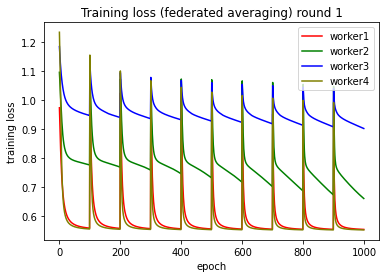

In [ ]:
plt.plot(train_loss_worker1[0:1000], color='red', label = 'worker1')
plt.plot(train_loss_worker2[0:1000], color='green', label = 'worker2')
plt.plot(train_loss_worker3[0:1000], color='blue', label = 'worker3')
plt.plot(train_loss_worker4[0:1000], color='olive', label = 'worker4')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.legend(loc='upper right')
plt.title("Training loss (fed avg) round 100 (100 epoch\round)")
plt.show()

## Federated max gradient aggregation

In [ ]:
worker1.clear_objects()                       ## clear worker1 object
worker2.clear_objects()
worker3.clear_objects()
worker4.clear_objects()
worker_trusted.clear_objects()

# Distribute data among the workers

In [ ]:
data_worker1 = x_tensor[0:40].send(worker1)
target_worker1 = y_tensor[0:40].send(worker1)

data_worker2 = x_tensor[40:80].send(worker2)
target_worker2 = y_tensor[40:80].send(worker2)

data_worker3 = x_tensor[80:120].send(worker3)
target_worker3 = y_tensor[80:120].send(worker3)

data_worker4 = x_tensor[110:].send(worker4)
target_worker4 = y_tensor[110:].send(worker4)

# Define model

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(4,50)                                   ## input neuron 4, output neuron 50
    self.fc2 = nn.Linear(50,100)                                 ## input neuron 50, output neuron 100
    self.output = nn.Linear(100,3)                               ## input neuron 100, ourput neuron 3 for three classes

  def forward (self,x):                                          ## define forward pass 
    x = F.relu(self.fc1(x))                                      ## call first fully connected layer and pass the result into relu activation
    x = F.relu(self.fc2(x))                                      ## call second fully connected layer and pass the result into relu activation
    x = F.softmax(self.output(x))                                ## pass into softmax function for multiclass classification
    return x

# Model training in each virtual worker

In [ ]:
num_round =100
criterion = nn.CrossEntropyLoss()

train_loss_worker1_fedmax = []
train_loss_worker2_fedmax = []
train_loss_worker3_fedmax = []
train_loss_worker4_fedmax = []

for round in range(num_round):
  model_worker1 = model.copy().send(worker1)
  model_worker2 = model.copy().send(worker2)
  model_worker3 = model.copy().send(worker3)
  model_worker4 = model.copy().send(worker4)
  
  opt_worker1 = optim.SGD(params=model_worker1.parameters(), lr = 0.01)
  opt_worker2 = optim.SGD(params=model_worker2.parameters(), lr = 0.01)
  opt_worker3 = optim.SGD(params=model_worker3.parameters(), lr = 0.01)
  opt_worker4 = optim.SGD(params=model_worker4.parameters(), lr = 0.01)
  opt_model = optim.SGD(params=model.parameters(), lr = 0.1)

  print('round'+str(round))

  for i in range(100):
    opt_worker1.zero_grad()
    pred_worker1 = model_worker1(data_worker1.float())
    _loss_worker1 = criterion(pred_worker1,target_worker1)
    _loss_worker1.backward()
    opt_worker1.step()
    loss_worker1 = _loss_worker1.get()
    train_loss_worker1_fedmax.append(loss_worker1.item())
    

    opt_worker2.zero_grad()
    pred_worker2 = model_worker2(data_worker2.float())
    _loss_worker2 = criterion(pred_worker2,target_worker2)
    _loss_worker2.backward()
    opt_worker2.step()
    loss_worker2 = _loss_worker2.get()
    train_loss_worker2_fedmax.append(loss_worker2.item())
    

    opt_worker3.zero_grad()
    pred_worker3 = model_worker3(data_worker3.float())
    _loss_worker3 = criterion(pred_worker3,target_worker3)
    _loss_worker3.backward()
    opt_worker3.step()
    loss_worker3 = _loss_worker3.get()
    train_loss_worker3_fedmax.append(loss_worker3.item())
    

    opt_worker4.zero_grad()
    pred_worker4 = model_worker4(data_worker4.float())
    _loss_worker4 = criterion(pred_worker4,target_worker4)
    _loss_worker4.backward()
    opt_worker4.step()
    loss_worker4 = _loss_worker4.get()
    train_loss_worker4_fedmax.append(loss_worker4.item())
    print('loss_worker1:'+str(loss_worker1)+ 'loss_worker2:'+str(loss_worker2)+'loss_worker3:'+str(loss_worker3)+
          'loss_worker4:'+str(loss_worker4))
  
  model_worker1.move(worker_trusted)
  model_worker2.move(worker_trusted)
  model_worker3.move(worker_trusted)
  model_worker4.move(worker_trusted)

  fc1_weight = (torch.max(model_worker1.fc1.weight, model_worker2.fc1.weight, model_worker3.fc1.weight, model_worker4.fc1.weight)).get()    ## calcualte max weight of first fully connected layer (four virtual worker)
  fc2_weight = (torch.max(model_worker1.fc2.weight.data,model_worker2.fc2.weight.data,model_worker3.fc2.weight.data,model_worker4.fc2.weight.data)).get()
  fc1_bias = (torch.max(model_worker1.fc1.bias.data,model_worker2.fc1.bias.data,model_worker3.fc1.bias.data,model_worker4.fc1.bias.data)).get()
  fc2_bias = (torch.max(model_worker1.fc2.bias.data,model_worker2.fc2.bias.data,model_worker3.fc2.bias.data,model_worker4.fc2.bias.data)).get()

  
  model.fc1.weight = torch.nn.parameter.Parameter(fc1_weight)              ## set max weight to model first fully connected layer
  model.fc2.weight = torch.nn.parameter.Parameter(fc2_weight)
  model.fc1.bias = torch.nn.parameter.Parameter(fc1_bias)
  model.fc2.bias = torch.nn.parameter.Parameter(fc2_bias)
  opt_model.step()                                                         ## update global model weight and bias


# Plot training loss (max gradient aggregation)

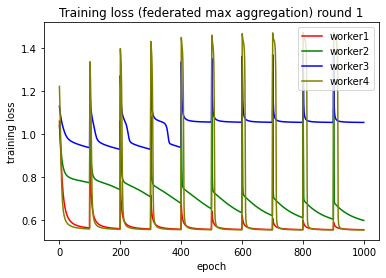

In [ ]:
plt.plot(train_loss_worker1_fedmax[0:1000], color='red', label = 'worker1')
plt.plot(train_loss_worker2_fedmax[0:1000], color='green', label = 'worker2')
plt.plot(train_loss_worker3_fedmax[0:1000], color='blue', label = 'worker3')
plt.plot(train_loss_worker4_fedmax[0:1000], color='olive', label = 'worker4')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.legend(loc='upper right')
plt.title("Training loss (fed max) round 100 (100 epoch\round")
plt.show( )

# Federated harmonic mean aggregation

In [ ]:
worker1.clear_objects()
worker2.clear_objects()
worker3.clear_objects()
worker4.clear_objects()
worker_trusted.clear_objects()

<VirtualWorker id:worker_trusted #objects:0>

# Data distribution among workers

In [ ]:
data_worker1 = x_tensor[0:40].send(worker1)
target_worker1 = y_tensor[0:40].send(worker1)

data_worker2 = x_tensor[40:80].send(worker2)
target_worker2 = y_tensor[40:80].send(worker2)

data_worker3 = x_tensor[80:120].send(worker3)
target_worker3 = y_tensor[80:120].send(worker3)

data_worker4 = x_tensor[110:].send(worker4)
target_worker4 = y_tensor[110:].send(worker4)

# Define model

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(4,50)                                   ## input neuron 4, output neuron 50
    self.fc2 = nn.Linear(50,100)                                 ## input neuron 50, output neuron 100
    self.output = nn.Linear(100,3)                               ## input neuron 100, ourput neuron 3 for three classes

  def forward (self,x):                                          ## define forward pass 
    x = F.relu(self.fc1(x))                                      ## call first fully connected layer and pass the result into relu activation
    x = F.relu(self.fc2(x))                                      ## call second fully connected layer and pass the result into relu activation
    x = F.softmax(self.output(x))                                ## pass into softmax function for multiclass classification
    return x

# Training each worker local model

In [ ]:
num_round = 100
criterion = nn.CrossEntropyLoss()

train_loss_worker1_fedh = []
train_loss_worker2_fedh = []
train_loss_worker3_fedh = []
train_loss_worker4_fedh = []

for round in range(num_round):
  model_worker1 = model.copy().send(worker1)
  model_worker2 = model.copy().send(worker2)
  model_worker3 = model.copy().send(worker3)
  model_worker4 = model.copy().send(worker4)
  
  opt_worker1 = optim.SGD(params=model_worker1.parameters(), lr = 0.01)
  opt_worker2 = optim.SGD(params=model_worker2.parameters(), lr = 0.01)
  opt_worker3 = optim.SGD(params=model_worker3.parameters(), lr = 0.01)
  opt_worker4 = optim.SGD(params=model_worker4.parameters(), lr = 0.01)
  opt_model = optim.SGD(params=model.parameters(), lr = 0.01)

  print('round'+str(round))

  for i in range(100):
    opt_worker1.zero_grad()
    pred_worker1 = model_worker1(data_worker1.float())
    _loss_worker1 = criterion(pred_worker1,target_worker1)
    _loss_worker1.backward()
    opt_worker1.step()
    loss_worker1 = _loss_worker1.get()
    train_loss_worker1_fedh.append(loss_worker1.item())
    

    opt_worker2.zero_grad()
    pred_worker2 = model_worker2(data_worker2.float())
    _loss_worker2 = criterion(pred_worker2,target_worker2)
    _loss_worker2.backward()
    opt_worker2.step()
    loss_worker2 = _loss_worker2.get()
    train_loss_worker2_fedh.append(loss_worker2.item())
    

    opt_worker3.zero_grad()
    pred_worker3 = model_worker3(data_worker3.float())
    _loss_worker3 = criterion(pred_worker3,target_worker3)
    _loss_worker3.backward()
    opt_worker3.step()
    loss_worker3 = _loss_worker3.get()
    train_loss_worker3_fedh.append(loss_worker3.item())
    

    opt_worker4.zero_grad()
    pred_worker4 = model_worker4(data_worker4.float())
    _loss_worker4 = criterion(pred_worker4,target_worker4)
    _loss_worker4.backward()
    opt_worker4.step()
    loss_worker4 = _loss_worker4.get()
    train_loss_worker4_fedh.append(loss_worker4.item())
    print('loss_worker1:'+str(loss_worker1)+ 'loss_worker2:'+str(loss_worker2)+'loss_worker3:'+str(loss_worker3)+
          'loss_worker4:'+str(loss_worker4))
  
  model_worker1.move(worker_trusted)
  model_worker2.move(worker_trusted)
  model_worker3.move(worker_trusted)
  model_worker4.move(worker_trusted)

  fc1_weight = ((1/(model_worker1.fc1.weight.data)+1/(model_worker2.fc1.weight.data)+1/(model_worker3.fc1.weight.data)+1/(model_worker4.fc1.weight.data))/4).get() ## calculate harmonic mean of first fully connected layer (four workers)  
  fc2_weight = ((1/(model_worker1.fc2.weight.data)+1/(model_worker2.fc2.weight.data)+1/(model_worker3.fc2.weight.data)+1/(model_worker4.fc2.weight.data))/4).get()
  fc1_bias = ((1/(model_worker1.fc1.bias.data)+1/(model_worker2.fc1.bias.data)+1/(model_worker3.fc1.bias.data)+1/(model_worker4.fc1.bias.data))/4).get()
  fc2_bias = ((1/(model_worker1.fc2.bias.data)+1/(model_worker2.fc2.bias.data)+1/(model_worker3.fc2.bias.data)+1/(model_worker4.fc2.bias.data))/4).get()

  
  model.fc1.weight = torch.nn.parameter.Parameter(fc1_weight)
  model.fc2.weight = torch.nn.parameter.Parameter(fc2_weight)
  model.fc1.bias = torch.nn.parameter.Parameter(fc1_bias)
  model.fc2.bias = torch.nn.parameter.Parameter(fc2_bias)
  opt_model.step()


# Ploting training loss (fed harmonic mean)

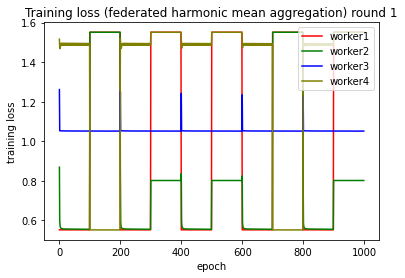

In [ ]:
plt.plot(train_loss_worker1_fedh[0:1000], color='red', label = 'worker1')
plt.plot(train_loss_worker2_fedh[0:1000], color='green', label = 'worker2')
plt.plot(train_loss_worker3_fedh[0:1000], color='blue', label = 'worker3')
plt.plot(train_loss_worker4_fedh[0:1000], color='olive', label = 'worker4')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.legend(loc='upper right')
plt.title("Training loss (fed max) round 100 (100 epoch\round")
plt.show( )